<a href="https://colab.research.google.com/github/matbest/StockTensorTimeSeries/blob/master/tensorflow%20LTSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install stockstats

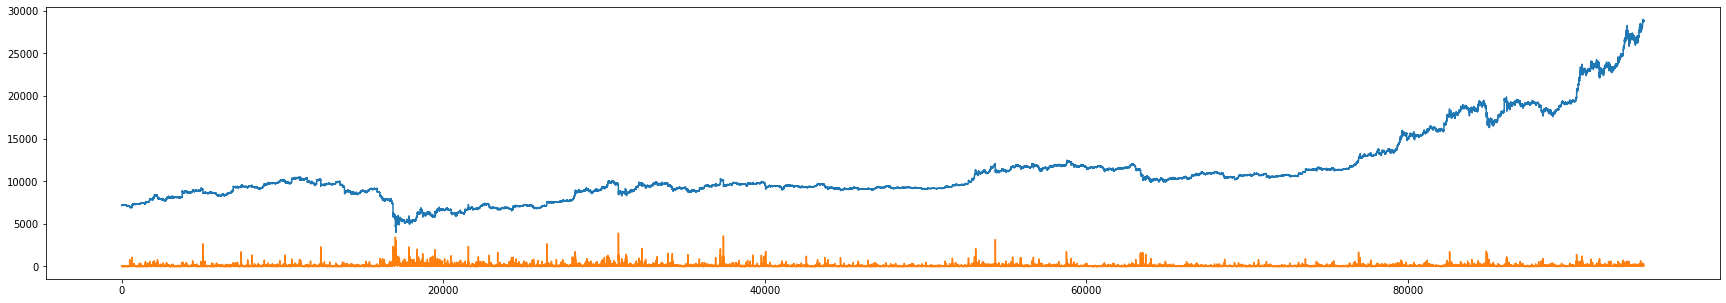

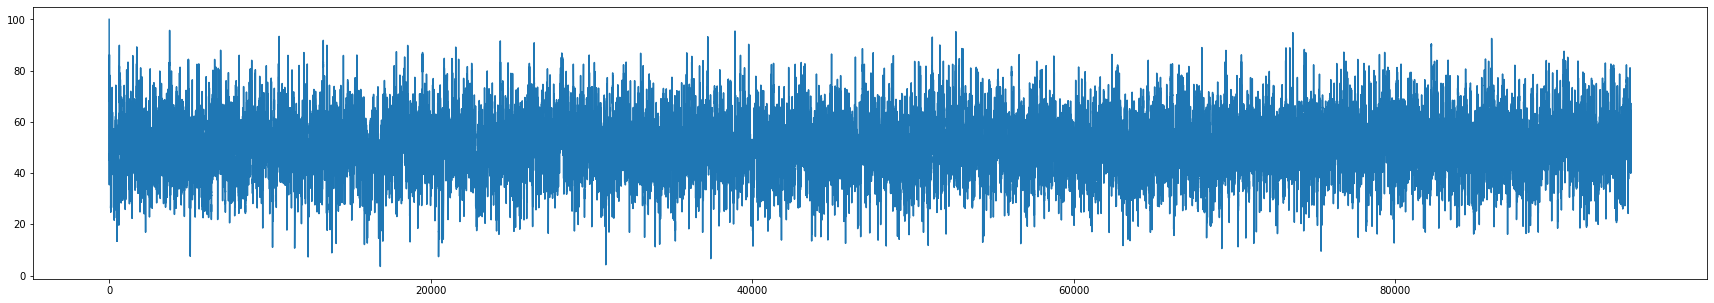

In [2]:

import pandas as pd
from stockstats import StockDataFrame as Sdf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import datetime

#original_data = pd.read_csv("2020_V1.csv"
#Click on the dataset in your repository, then click on View Raw. 
url = 'https://raw.githubusercontent.com/matbest/StockTensorTimeSeries/master/Data/Input/2020_V1.csv'
original_data = pd.read_csv(url)

original_data.dropna()
stock = Sdf.retype(original_data)

#data.hist()
plt.figure(figsize=(30,5))
plt.plot(original_data['open'])
plt.plot(original_data['volume'])
plt.show()
plt.figure(figsize=(30,5))
plt.plot(stock['rsi_14'])
plt.show()

# Moving average forecast

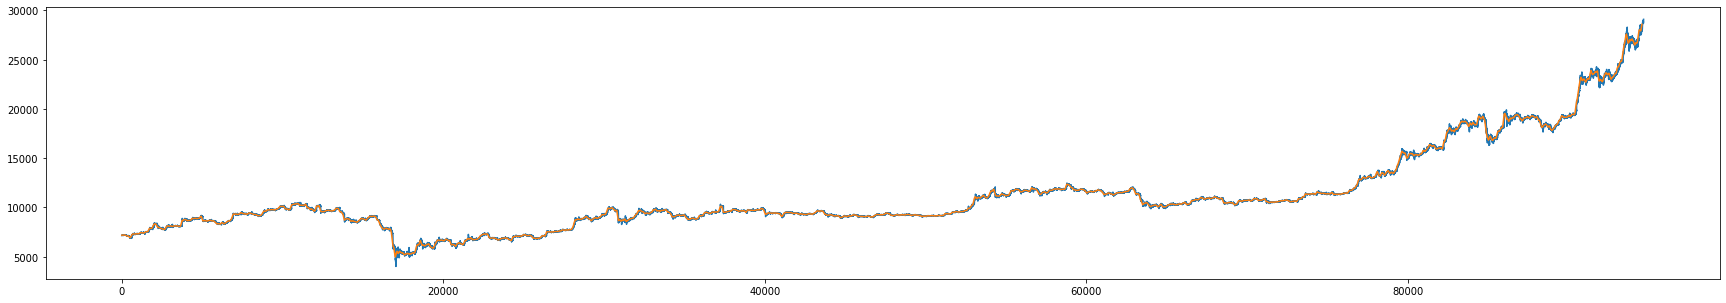

18793.831106416532
81.87261798295697


In [3]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

series = original_data['close']
window = 100
moving_avg = moving_average_forecast(original_data['close'], window)
plt.figure(figsize=(30,5))
series.plot()

plt.plot(moving_avg)
plt.show()

print(keras.metrics.mean_squared_error(series[:-window], moving_avg).numpy())
print(keras.metrics.mean_absolute_error(series[:-window], moving_avg).numpy())

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 701041380066519157
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14674281152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12179226952184543908
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [5]:

!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
import string
from subprocess import run
print( run(['nvidia-smi'], capture_output=True, text=True).stdout.replace('\\n', '\n').replace('\\t', '\t'))


Fri Mar 12 19:45:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W /  70W |    230MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Deep Neural Networks (DNN) one layer, linear regression

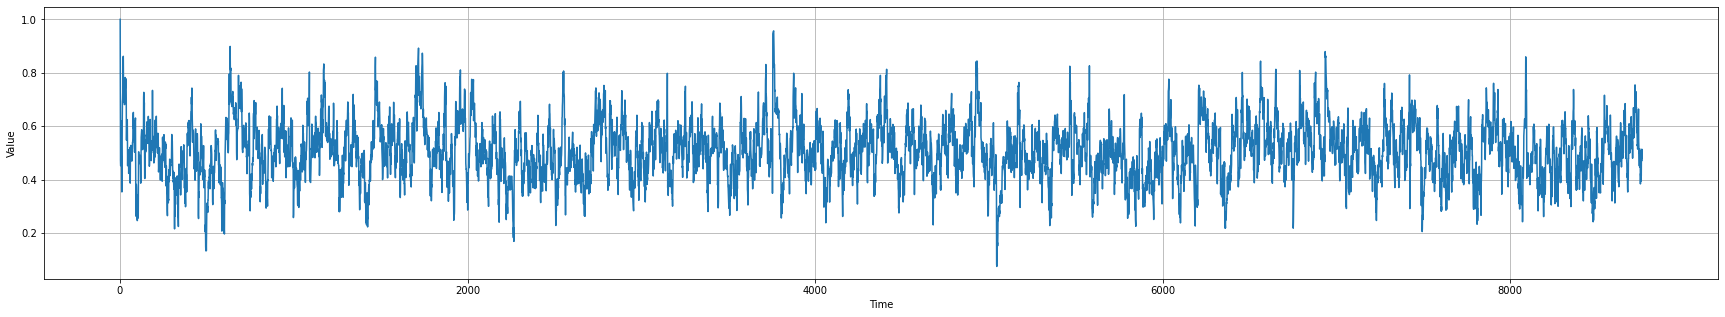

In [6]:
sampleMonth = 8760
#data = original_data['close'].head(sampleMonth * 2).to_numpy()
data =stock['rsi_14'].head(sampleMonth * 2).to_numpy()/100 # Work with RSI rather than raw numbers, and place between 0 to 1.

time = np.arange(sampleMonth * 2, dtype="float32")

split_time = sampleMonth

time_train = time[:split_time]
x_train = data[:split_time]

time_valid = time[split_time:]
x_valid = data[split_time:]

def plot_series(time, series, format="-", start=0, end=None):
    plt.figure(figsize=(30,5))
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


plot_series(time_train, x_train)

window_size = int(sampleMonth * 0.014)
batch_size = int(sampleMonth * 0.022)
shuffle_buffer_size = split_time

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def data_summary(train):
    """Summarize current state of dataset"""
    print('Train  shape:', train.shape)

In [8]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 123       
Total params: 123
Trainable params: 123
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit?

In [9]:
print("Layer weights {}".format(l0.get_weights()))

#model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=0.000055,  momentum=0.010, nesterov=True))
#model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.0,  clipvalue=1.))
#model.fit(dataset,epochs=10,verbose=1)


model.compile(optimizer='sgd', loss='mse')
# This builds the model for the first time:
#model.fit(x, y, batch_size=32, epochs=10,verbose=1)
model.fit(dataset,epochs=10,verbose=1)


print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[ 0.00805329],
       [-0.07112186],
       [-0.16401058],
       [-0.16314451],
       [-0.21382408],
       [-0.01026022],
       [ 0.19226025],
       [ 0.15091942],
       [-0.15274039],
       [ 0.14592476],
       [-0.20975472],
       [-0.06152681],
       [-0.18942732],
       [-0.07499526],
       [ 0.1219783 ],
       [ 0.1618454 ],
       [ 0.00259992],
       [-0.20878062],
       [-0.21450657],
       [-0.09526828],
       [-0.1322895 ],
       [-0.07930969],
       [ 0.07387124],
       [ 0.19295333],
       [-0.18793637],
       [-0.1339907 ],
       [ 0.15885569],
       [-0.17999008],
       [-0.1397329 ],
       [-0.18880433],
       [ 0.1295328 ],
       [-0.19861948],
       [-0.16679902],
       [ 0.19791387],
       [ 0.06223132],
       [-0.08437042],
       [ 0.12124212],
       [ 0.19405968],
       [ 0.176226  ],
       [-0.12060066],
       [-0.17372844],
       [-0.0396678 ],
       [ 0.1328076 ],
       [-0.03379823],
       [-0.160002

In [ ]:
forecast = []

for t in range(len(data) - window_size):
    predict = model.predict(data[t:t + window_size][np.newaxis])
    forecast.append(predict)

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

KeyboardInterrupt: ignored

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()